In [165]:
# !pip install networkx
# !pip install matplotlib
# !pip install tqdm
# !pip install pandas
# !pip install numpy
# !pip install graphviz
# !pip install scikit-learn

In [166]:
import random
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations, groupby

from networkx.algorithms import tree
from networkx.algorithms import bellman_ford_predecessor_and_distance
from networkx.algorithms import floyd_warshall_predecessor_and_distance

import numpy.typing as npt

from tqdm import tqdm
import time

# Algorithm and Experiment Analysis

**Authors**: Пілецька Єлизавета, Рихальський Михайло

## Task Overview
- Implemented custom algorithms for graph and tree problems.
- Analyzed the performance of algorithms and compare them with built-in solutions.
- Used data visualization to showcase performance.

# Task 1. Algorithm's analysis

## Generating a graph

In [167]:

# You can use this function to generate a random graph with 'num_of_nodes' nodes
# and 'completeness' probability of an edge between any two nodes
# If 'directed' is True, the graph will be directed
# If 'draw' is True, the graph will be drawn
def gnp_random_connected_graph(num_of_nodes: int,
                               completeness: int,
                               directed: bool = False,
                               draw: bool = False,
                               negative: bool = True):
    """
    Generates a random graph, similarly to an Erdős-Rényi 
    graph, but enforcing that the resulting graph is conneted (in case of undirected graphs)
    """

    
    if directed:
        G = nx.DiGraph()
    else:
        G = nx.Graph()
    edges = combinations(range(num_of_nodes), 2)
    G.add_nodes_from(range(num_of_nodes))
    
    for _, node_edges in groupby(edges, key = lambda x: x[0]):
        node_edges = list(node_edges)
        random_edge = random.choice(node_edges)
        if random.random() < 0.5:
            random_edge = random_edge[::-1]
        G.add_edge(*random_edge)
        for e in node_edges:
            if random.random() < completeness:
                G.add_edge(*e)
                
    for (u,v,w) in G.edges(data=True):
        if negative:
            w['weight'] = random.randint(-5, 20)
        else:
            w['weight'] = random.randint(0, 25)
                
    if draw: 
        plt.figure(figsize=(10,6))
        if directed:
            # draw with edge weights
            pos = nx.arf_layout(G)
            nx.draw(G,pos, node_color='lightblue', 
                    with_labels=True,
                    node_size=500, 
                    arrowsize=20, 
                    arrows=True)
            labels = nx.get_edge_attributes(G,'weight')
            nx.draw_networkx_edge_labels(G, pos,edge_labels=labels)
            
        else:
            nx.draw(G, node_color='lightblue', 
                with_labels=True, 
                node_size=500)
        
    return G

## Subtask 1.1
## Algorithm Implementation
### 1. Prim's Algorithm
- This algorithm finds the Minimum Spanning Tree (MST) for a graph.
- Handles both directed and undirected graphs.

#### Code:

In [168]:
def shortest_connection(G: nx.Graph) -> set[tuple[int, int]]:
    """
    Prim's algorithm (finding minimal spanning tree)
    for both directed and undirected Graphs
    """
    graph = {u: {} for u in G.nodes()}
    # creating a nested graph data structure
    for u, v, data in G.edges(data=True):
        graph[u][v] = data['weight']
        if not isinstance(G, nx.DiGraph):
            graph[v][u] = data['weight']
    
    minimal_spanning_tree = set()
    accessible = {next(iter(G.nodes()))}
    disconnected = set(G.nodes()) - accessible
    # add edges to disconnected nodes while there are any
    while len(disconnected) != 0:
        best_option = (None,None,float('inf'))
        for u in accessible:
            for v in disconnected:
                if v in graph[u] and graph[u][v] < best_option[2]:
                    best_option = (u, v, graph[u][v])
        if best_option[2] == float('inf'):
            raise ValueError("Impossible to connect the graph")
        
        u, v, w = best_option
        disconnected.remove(v)
        accessible.add(v)
        minimal_spanning_tree.add((u, v))
    
    return minimal_spanning_tree


## Example:

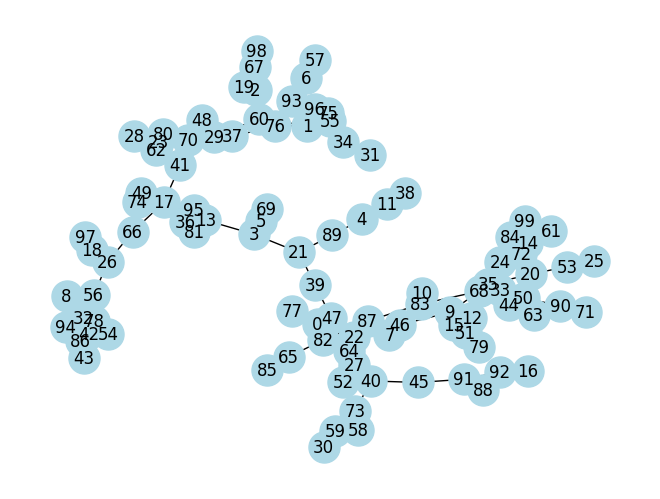

In [169]:
G = gnp_random_connected_graph(100, 0.5, False)
mstp = shortest_connection(G)
G = nx.Graph()
G.add_edges_from(mstp)
nx.draw(G, node_color='lightblue', 
    with_labels=True, 
    node_size=500)

## Functions for testing and plotting algorithm comparisons:

In [170]:
def plot_algorithm_performance(data):
    x_builtin = sorted([key[1] for key in data.keys() if key[0] == 'builtin'])
    y_builtin = [data[('builtin', n)] for n in x_builtin]

    x_mine = sorted([key[1] for key in data.keys() if key[0] == 'mine'])
    y_mine = [data[('mine', n)] for n in x_mine]

    plt.figure(figsize=(8, 5))
    plt.plot(x_builtin, y_builtin, marker='o', linestyle='-', label="Built-in Algorithm")
    plt.plot(x_mine, y_mine, marker='s', linestyle='-', label="My Algorithm")

    plt.xlabel("Input Size (n)")
    plt.ylabel("Execution Time (seconds)")
    plt.title("Performance Comparison: Built-in vs. My Algorithm")
    plt.legend()
    plt.grid(True)

    plt.show()

def test_algos(times, completeness, algo_type):
    data = {}
    for nd in times:
        NUM_OF_ITERATIONS = 1000
        time_taken_builtin = 0
        time_taken_mine = 0
        for i in tqdm(range(NUM_OF_ITERATIONS)):
            if algo_type == 'prim':
                G = gnp_random_connected_graph(nd, completeness , False)
            else:
                G = gnp_random_connected_graph(nd, completeness, negative=False)

            start = time.time()
            if algo_type == 'prim':
                tree.minimum_spanning_tree(G, algorithm="prim")
            else:
                bellman_ford_predecessor_and_distance(G, 0)
            end = time.time()

            time_taken_builtin += end - start

            start = time.time()
            if algo_type == 'prim':
                shortest_connection(G)
            else:
                bellman_ford(G, 0)
            end = time.time()
            time_taken_mine += end - start

        builtin = time_taken_builtin / NUM_OF_ITERATIONS
        mine = time_taken_mine / NUM_OF_ITERATIONS
        data[('builtin', nd)] = builtin
        data['mine', nd] = mine
    return data

## Analysis

The built-in implementation of Prim's algorithm in NetworkX outperforms the custom implementation in terms of execution time and scalability. The results emphasize the importance of using optimized, library-provided algorithms for large-scale and complex computations. While the custom implementation is useful for understanding the algorithm's workings, it is not suitable for practical applications involving large or dense graphs.

100%|██████████| 1000/1000 [00:12<00:00, 81.37it/s]


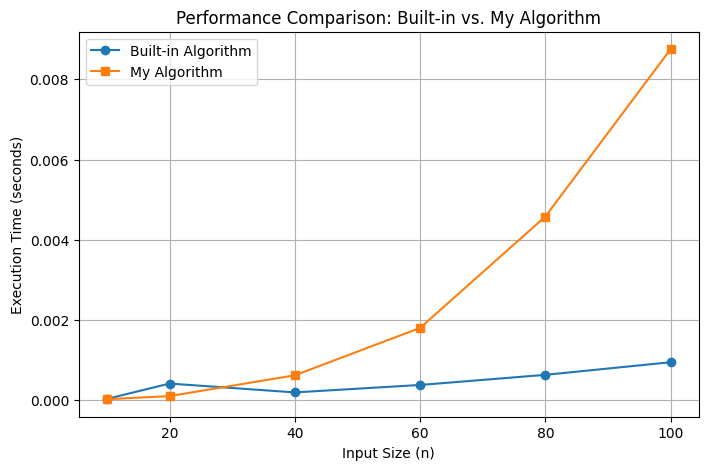

In [171]:
data = test_algos((10, 20, 40, 60, 80, 100), 0.4, 'prim')
plot_algorithm_performance(data)

The first comparison shows that the builtin algorithm performs significantly better for larger graphs

100%|██████████| 1000/1000 [00:15<00:00, 65.43it/s]


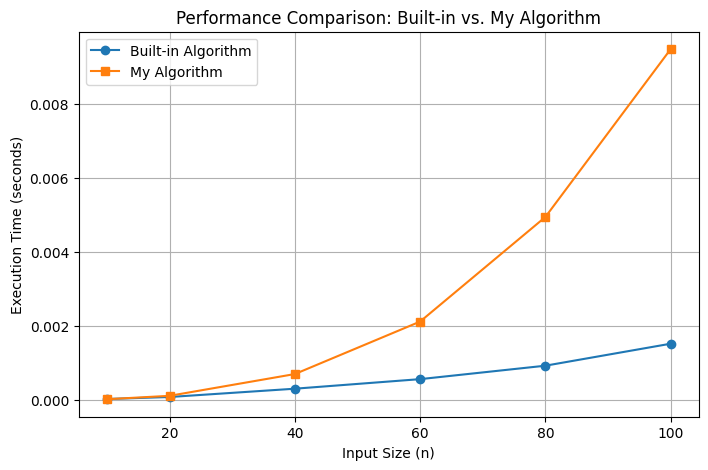

In [172]:
data = test_algos((10, 20, 40, 60, 80, 100), 0.7, 'prim')
plot_algorithm_performance(data)

The second comparison shows that for denser graphs the difference gets a little smaller, even though the builtin algorithm is still much faster


100%|██████████| 1000/1000 [00:17<00:00, 56.07it/s]


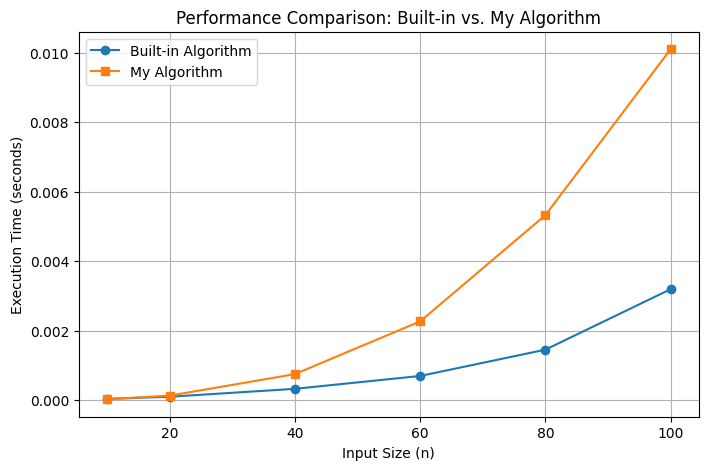

In [173]:
data = test_algos((10, 20, 40, 60, 80, 100), 1, 'prim')
plot_algorithm_performance(data)

The graph with density = one reduces the difference even more, however it is still large.

## Subtask 1.2
### 2. Bellman-Ford Algorithm
- Finds the shortest path from a single source to all other vertices.

#### Code:

In [174]:
def bellman_ford(G: nx.Graph, start_node: int) -> tuple[dict[int, int], dict[int, int]]:
    """
    Bellman-Ford's algorithm for finding the shortest path from a start node
    to all other nodes in a graph. This implementation handles both directed and undirected graphs.
    """
    graph = {}

    for u, v, data in G.edges(data=True):
        graph[(u, v)] = data['weight']

    distances = {}
    predecessors = {}
    for node in G.nodes:
        distances[node] = None
        predecessors[node] = None
        
    accessible = {start_node}
    disconnected = set(G.nodes()) - accessible
    if distances[start_node] is None:
        distances[start_node] = 0

    for _ in range(len(G.nodes) - 1):
        changed_nodes = set()
        for (u, v), weight in graph.items():
            if u in accessible and (distances[v] is None or distances[u] + weight < distances[v]):
                distances[v] = distances[u] + weight
                predecessors[v] = u
                accessible.add(v)
                disconnected.discard(v)
                changed_nodes.add(v)
        if not changed_nodes:
            break

    return predecessors, {k: v for k, v in distances.items() if v is not None}

## Usage Example:

In [176]:
# pred is a dictionary of predecessors, dist is a dictionary of distances
G = gnp_random_connected_graph(5, 0.5, True, False)
try:
    pred, dist = bellman_ford(G, 0)
    for k, v in dist.items():
        print(f"Distance to {k}:", v)
except nx.NetworkXUnbounded:
    print("Negative cycle detected")

Distance to 0: 0
Distance to 3: 20
Distance to 4: 9


## Analysis

The custom Bellman-Ford implementation outperforms the built-in version for sparse graphs due to reduced overhead. However, as graph density increases, the built-in implementation becomes a little faster. This means that the implementation of the custom algorithm is close to the complexity of the builtin algorithm, as the difference between the run times is close to constant.

100%|██████████| 1000/1000 [00:14<00:00, 67.77it/s]


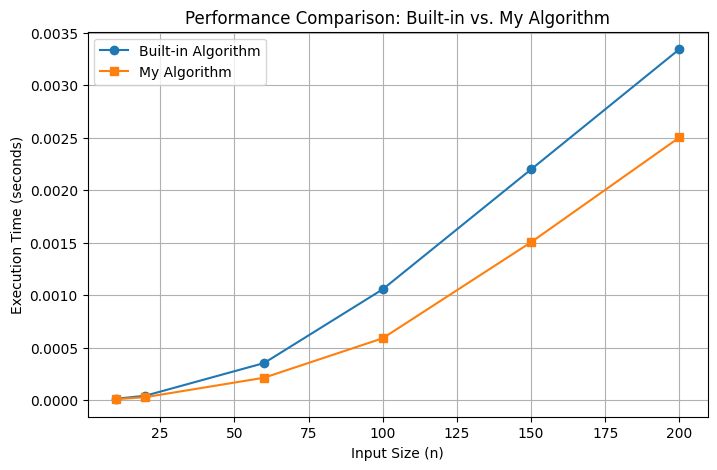

In [177]:
data = test_algos((10, 20, 60, 100, 150, 200), 0.4, 'bellman')
plot_algorithm_performance(data)

On the first run, the custom algorithm slightly outperforms the builtin

100%|██████████| 1000/1000 [00:22<00:00, 44.68it/s]


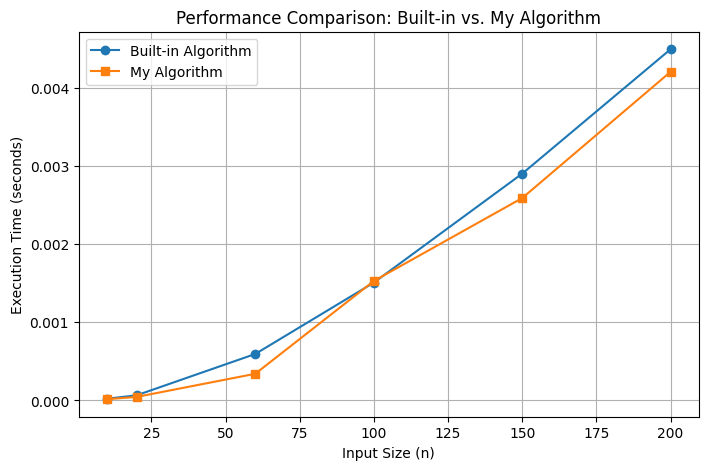

In [179]:
data = test_algos((10, 20, 60, 100, 150, 200), 0.7, 'bellman')
plot_algorithm_performance(data)

With a denser graph, the difference decreases and the algorithms perform really similar

100%|██████████| 1000/1000 [00:31<00:00, 31.83it/s]


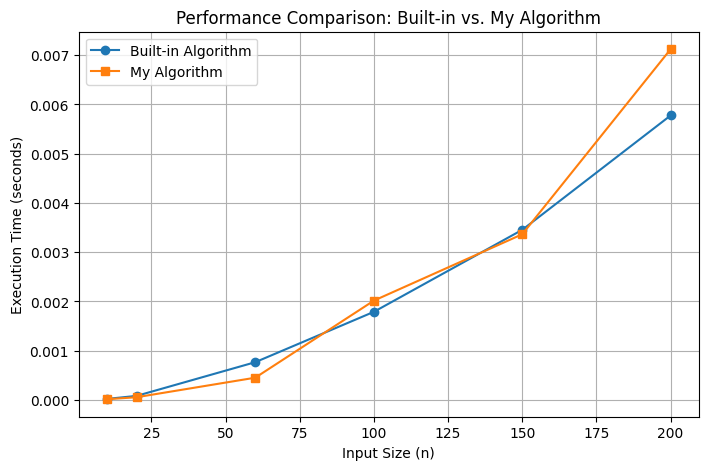

In [180]:
data = test_algos((10, 20, 60, 100, 150, 200), 1, 'bellman')
plot_algorithm_performance(data)

With a full graph, the builin algorithm slightly outperforms the custom one, 
even though they were really close with smaller graphs (up to 150 nodes)

## Task 2: Decision Tree Classifier

The objective of this task is to implement a custom Decision Tree Classifier.
- The Iris dataset was used as input.
- A custom Decision Tree Classifier was implemented and trained.
- The classifier's accuracy was evaluated.

In [181]:
from sklearn.datasets import load_iris
from sklearn import tree
from sklearn.model_selection import train_test_split

In [182]:

class Node:
    def __init__(self, X: npt.NDArray, y: npt.NDArray):
        """
        :param X: numpy array of form [[feature1,feature2, ... featureN], ...] (i.e. [[1.5, 5.4, 3.2, 9.8] , ...] for case with iris d.s.)
        :param y: numpy array of from [class1, class2, ...] (i.e. [0,1,1,2,1,0,...] for case with iris d.s.)
        """

        self.X = X
        self.y = y
        self.feature_index = 0
        self.threshold = 0
        self.left = None
        self.right = None

In [183]:
class DecisionTreeClassifier:
    def __init__(self, max_depth: int, min_samples_split: int = 2) -> None:
        self.max_depth = max_depth
        self.tree = None
        self.number_of_classes = None
        self.min_samples_split = min_samples_split
        
        
    def fit(self, X: npt.NDArray, y: npt.NDArray) -> None:
        """
        Function that performs all the training (building of a tree).
        self.tree is a root node of the tree that references other nodes
        X: input data
        y: target data
        """
        self.number_of_classes = np.unique(y).size
        self.tree = self.build_tree(X, y)

    def build_tree(self, X, y, depth=0):
        """
        Recursively builds a decision tree, implementing the
        core logic of the Class.
        """
        # Base cases
        if len(np.unique(y)) == 1:
            return {"value": y[0]}
        if depth >= self.max_depth or len(y) < self.min_samples_split:
            return {"value": np.mean(y) if np.issubdtype(y.dtype, np.number) else np.argmax(np.bincount(y))}

        # Find the best split
        best_feature, best_threshold, best_score = self.get_best_split(X, y)
        if best_feature is None:
            return {"value": np.mean(y) if np.issubdtype(y.dtype, np.number) else np.argmax(np.bincount(y))}

        # Recursively build tree
        left_mask = X[:, best_feature] <= best_threshold
        right_mask = ~left_mask
        left_child = self.build_tree(X[left_mask], y[left_mask], depth + 1)
        right_child = self.build_tree(X[right_mask], y[right_mask], depth + 1)

        # Return the current node
        return {
            "feature": best_feature,
            "threshold": best_threshold,
            "left": left_child,
            "right": right_child
        }

    def get_best_split(self, X, y):
        """
        Finds the best way to split the data.
        Loop through all features and thresholds, calculate the
        score for each one and choose the best.
        """
        best_feature, best_threshold, best_score = None, None, float("inf")
        for feature_index in range(X.shape[1]):
            thresholds = np.unique(X[:, feature_index])
            for threshold in thresholds:
                left_mask = X[:, feature_index] <= threshold
                right_mask = ~left_mask
                if sum(left_mask) == 0 or sum(right_mask) == 0:
                    continue

                score = self.calculate_impurity(y[left_mask], y[right_mask])
                if score < best_score:
                    best_feature = feature_index
                    best_threshold = threshold
                    best_score = score

        return best_feature, best_threshold, best_score

    @staticmethod
    def calculate_impurity(y_left, y_right):
        """
        Calculates Gini impurity for both subsets to determine the best score
        in get_best_split.
        """
        total = len(y_left) + len(y_right)
        gini_left = 1.0 - sum((np.sum(y_left == c) / len(y_left)) ** 2 for c in np.unique(y_left))
        gini_right = 1.0 - sum((np.sum(y_right == c) / len(y_right)) ** 2 for c in np.unique(y_right))
        return (len(y_left) / total) * gini_left + (len(y_right) / total) * gini_right

    def predict(self, X_test: npt.NDArray) -> list:
        """
        Traverse the tree while there is a child
        and return the predicted class for it.
        Returns a list of predictions for all test samples.
        """
        predictions = []
        for sample in X_test:
            node = self.tree 
            while "value" not in node:
                feature = node["feature"]
                threshold = node["threshold"]
                if sample[feature] <= threshold:
                    node = node["left"]
                else:
                    node = node["right"]
            predictions.append(node["value"])
        return predictions

## Perfomance evaluation

Below you can find the code that 
evaluates the accuracy of the DTC
on the Iris dataset.

In [184]:
def evaluate(X, X_test, y, y_test) -> float:
    """
    Returns accuracy of the model (ratio of right guesses to the number of samples)
    """
    clf = DecisionTreeClassifier(5)
    clf.fit(X, y)
    predictions = clf.predict(X_test)

    correct_predictions = sum(p == t for p, t in zip(predictions, y_test))
    accuracy = correct_predictions / len(y_test)

    return accuracy


iris = load_iris()
X, y = iris.data, iris.target
evaluation = evaluate(*train_test_split(X, y, test_size=0.20))
print(evaluation)

0.9666666666666667
